# Autoencoders

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/m12sl/dl-hse-2021/blob/master/12-xae/seminar.ipynb)

Пора заняться автоэнкодерами.

<img src="https://github.com/m12sl/dl-hse-2021/raw/master/12-xae/img/encoder.png" crossorigin="anonymous"/>

План:
- познакомиться с идеей AE
- написать класс для работы с AE
- посмотреть на внутренние представления
- провести эксперимент с интерполяцией представлений

# Что такое Автоэнкодер?

Обычно это модель состоящая из энкодера и декодера.

Энкодер переводит входные примеры во внутренее представление (вектор или тензор с пространственными размерностями), декодер переводит внутренее представление обратно в пространство примеров.

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
import os
from pathlib import Path

from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

# MNIST или FashionMNIST
DATA_ROOT = './tmp'

class VeryMNIST:
    def __init__(self, root, train=False, transform=None):
        self.ds = datasets.MNIST(root, train=train, download=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, item):
        img, label = self.ds[item]
        if self.transform is not None:
            img = self.transform(img)
        return {"image": img, "label": label}

mnist_train = VeryMNIST(DATA_ROOT, train=True, transform=transforms.ToTensor())
mnist_val = VeryMNIST(DATA_ROOT, train=False, transform=transforms.ToTensor())

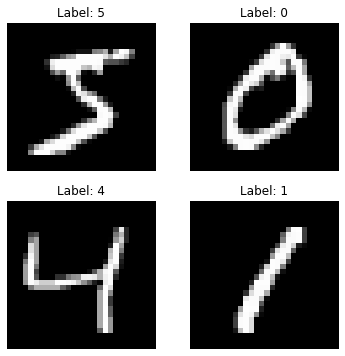

In [26]:
plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    ddict = mnist_train[i]
    
    img, label = ddict['image'], ddict['label']
    plt.title("Label: {}".format(label))
    plt.imshow(img[0, ...], cmap='gray')
    plt.axis('off')

Для тренировки возьмем наш обычный Trainer-класс.

Подразумевается что в классе модели реализован метод `compute_all(batch)`, который возвращает `loss` и `details_dict`.

In [67]:
class Trainer:
    def __init__(self, model: nn.Module,
                 batch_size: int = 128,
                 run_folder: str = "./runs"):
        self.model = model
        self.batch_size = batch_size
        
        run_folder = Path(run_folder)
        train_log_folder = run_folder / "train_log"
        val_log_folder = run_folder / "val_log"
        print(f"Run output folder is {run_folder}")
        os.makedirs(run_folder, exist_ok=True)
        os.makedirs(train_log_folder, exist_ok=True)
        os.makedirs(val_log_folder, exist_ok=True)

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)
        
        self.run_folder = run_folder
        self.global_step = 0
        self.train_writer = SummaryWriter(log_dir=str(train_log_folder))
        self.val_writer = SummaryWriter(log_dir=str(val_log_folder))

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs: int, lr: float):
        model = self.model
        optimizer = model.get_optimizer(lr=lr)

        train_loader = model.get_loader(train=True)
        val_loader = model.get_loader(train=False)

        best_loss = float('inf')

        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                for k, v in details.items():
                    self.train_writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1

            model.eval()
            metrics = defaultdict(list)
            val_losses = []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                for k, v in details.items():
                    metrics[k].append(v)
                val_losses.append(loss.item())
            
            metrics = {k: np.mean(v) for k, v in metrics.items()}
            
            for k, v in metrics.items():
                self.val_writer.add_scalar(k, v, global_step=self.global_step)

            val_loss = np.mean(val_losses)
            if val_loss < best_loss:
                self.save_checkpoint(str(self.run_folder / "best_checkpoint.pth"))
                best_loss = val_loss
                
            self.val_writer.flush()
            
    def find_lr(self, min_lr: float = 1e-6,
                max_lr: float = 1e-1,
                num_lrs: int = 1000,
                smooth_beta: float = 0.8) -> dict:
        
        model = self.model
        optimizer = model.get_optimizer(lr=min_lr)
        train_loader = model.get_loader(train=True)
        
        num_lrs = min(num_lrs, len(train_loader))
        lrs = np.geomspace(start=min_lr, stop=max_lr, num=num_lrs)
        logs = {'lr': [], 'loss': [], 'avg_loss': []}
        avg_loss = None

        initial_state = model.state_dict()
        model.train()
        for lr, batch in tqdm(zip(lrs, train_loader), desc='finding LR', total=num_lrs):
            # apply new lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            # train step
            batch = {k: v.to(self.device) for k, v in batch.items()}
            loss, details = model.compute_all(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss = loss.item()

            # calculate smoothed loss
            if avg_loss is None:
                avg_loss = loss
            else:
                avg_loss = smooth_beta * avg_loss + (1 - smooth_beta) * loss

            # store values into logs
            logs['lr'].append(lr)
            logs['avg_loss'].append(avg_loss)
            logs['loss'].append(loss)

        logs.update({key: np.array(val) for key, val in logs.items()})
        model.load_state_dict(initial_state)
        return logs

## Обычный автоэнкодер


Run output folder is ae-2


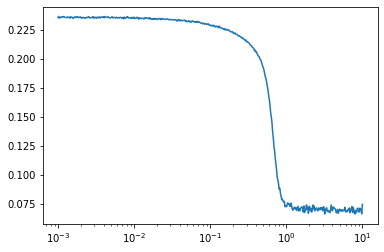

In [68]:
class AE(nn.Module):
    def __init__(self, hidden_size=2, lr=1e-2):
        super().__init__()
        self.encoder = nn.Sequential(nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, hidden_size))
        self.decoder = nn.Sequential(nn.Linear(hidden_size, 256), nn.ReLU(), nn.Linear(256, 784), nn.Sigmoid())
        self.lr = lr
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def get_optimizer(self, lr):
        return torch.optim.SGD(self.parameters(), lr=lr)
    
    def get_loader(self, train=False, batch_size=128):
        if train:
            ds = mnist_train
        else:
            ds = mnist_val
        return DataLoader(ds, batch_size=batch_size, shuffle=train)
        
    def compute_all(self, batch):
        x = batch['image']
        x = x.view(-1, 784)
        z = self.encode(x)
        xr = self.decode(z)
        
        loss = F.mse_loss(xr, x)
        
        return loss, dict(
            loss=loss.item(),
        )
        

ae = AE(hidden_size=2, lr=1e-1)
trainer = Trainer(ae, run_folder="ae-2", batch_size=16)

lrrt = trainer.find_lr(min_lr=1e-3, max_lr=10.0)

plt.plot(lrrt['lr'], lrrt['loss'])
plt.xscale('log')


In [69]:
trainer.train(10, lr=1.0)

KeyboardInterrupt: 

Оригинал и восстановление.

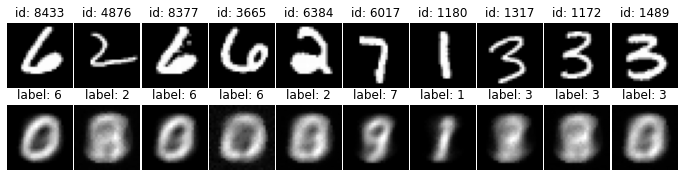

In [70]:
def reconstruction_plot(model, dataset):
    plt.figure(figsize=[12, 3])
    N = 10
    idx = np.random.choice(len(dataset), size=N)
    for i in range(N):
        plt.subplot(2, N, i + 1)
        ddict = dataset[idx[i]]
        img = ddict['image']
        label = ddict["label"]
        
        with torch.no_grad():
            z = ae.encoder(img.view(-1, 784))
            rec = ae.decoder(z)
            rec = rec.view(28, 28).cpu().numpy()
            
        plt.title("id: {}".format(idx[i]))
        plt.imshow(img[0, ...], cmap='gray')
        plt.axis('off')

        plt.subplot(2, N, i + 1 + N)
        plt.title('label: {}'.format(label))
        plt.imshow(rec, cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.03, hspace=0)
    
reconstruction_plot(ae, mnist_val)

Двумерные представления

In [ ]:
# посмотрим на внутренние представления
def code_distribution(model, dataset):
    N = 1000
    idx = np.random.choice(len(dataset), size=N)
    
    <your code here>
    x, y, colors = ...
    
    # если в x, y, colors лежат координаты и метки, то следующий код выведет график с легендой
    cm=plt.cm.rainbow(np.linspace(0,1,10))
    plt.figure(figsize=(12, 12))
    plt.scatter(x, y, c=cm[np.array(colors)])
    plt.grid()
    plt.legend(handles=[mpatches.Patch(color=cm[i], label='{}'.format(i)) for i in range(10)])
    plt.show()
    
code_distribution(ae, mnist_train)

Интерполяция

In [ ]:
def plot_interpolations(model, dataset):
    N = 10
    idx = np.random.choice(len(dataset), size=N)
    
    # your code here
    out = ...
    # end of your code
    # если out имеет размер [5, 10, 28, 28], следующий код нарисует таблицу с интерполяционными картинками
    
    fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(14, 7),
                             subplot_kw={'xticks': [], 'yticks': []})
    
    for i in range(50):
        axes[i // 10, i % 10].imshow(out[i // 10, i % 10], cmap='gray')
    

plot_interpolations(ae, mnist_val)

**Какие особенности вы видите на этих картинках?**

## Вариационный автоэнкодер (не Байесовский вывод)


Предположим, мы хотим, чтобы `code` был распределен нормально (стандартное 2d распределение).
Будем 


1. Как сделать одно распредление похожим на другое? Минимизировать KL-дивергеницю!
 
 $KL(q(x)||p(x)) = \int q(x) \log \frac{q(x)}{p(x)}$
 
2. Как сделать из `code` распределение, а не одну точку? Давайте сделаем из него распределение!
 
 $z = \mu + \varepsilon \sigma$ где $code = [\mu, \sigma]$, а $\varepsilon \sim N(0, 1)$
 
3. Мы можем не прописывать все распределение. Между модельными распредлениями дивергенцию можно прописать аналитически.

 $z \sim N(\mu, \sigma)$
 
 $KL = \sum\limits_{i} \mu^2 + \sigma^2 - \log \sigma - 1$
 
 
<img src="https://github.com/m12sl/dl-hse-2020/raw/master/11-prob-models/img/vae.png" crossorigin="anonymous"/>
 
 




## Что можно посмотреть про байесовский вывод?
- [Лекция Ветрова DeepBayes2017. Модели с латентными переменными](https://youtu.be/7yLOF07Mv5I)
- [Лекция Ветрова DeepBayes2017. Масштабируемые байесовские методы](https://youtu.be/if9bTlZOiO8) << тут про VAE
- [Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)
- [Tutorial on Variational Autoencoders](https://arxiv.org/pdf/1606.05908.pdf)
- [blogpost](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)
- [KL дивергенция между двумя нормальными распределениями](https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians)



# Делаем вариационный автоэнкодер с сжатым внутренним представление

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ...
        self.decoder = ...
        
    def compute_all(self, inp):
        <your code here>
        return dict(
            loss=loss,
            metrics=dict(
                # любые метрики на ваш вкус
                kld=kld.item(),
                loss=loss.item(),
            )
        )
vae = VAE()
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_model(vae, opt, mnist_train, mnist_val, epochs=3)

In [ ]:
reconstruction_plot(vae, mnist_val)

In [ ]:
code_distribution(vae, mnist_train)

In [ ]:
plot_interpolations(ae, mnist_val)

Полезные применения (*)автоэнкодеров:
 - претрейн на неразмеченных данных
 - уменьшение размерности
 - полезные для других моделей представления
 - трактуемые внутренние представления
 - детектирование аномалий
 - denoising
 - манипуляции внутренними представлениями
 - синтез новых примеров
 - ...


Для решения некоторых из этих задач не обязательно завязываться на encoder-decoder-архитектуру, посмотрите на i-RevNets (Invertible Reversible Networks): 